In [ ]:
from __future__ import print_function
import torch
import torch.optim as optim

!pip install torchsummary
from torchsummary import summary

from eva.model import Net
from eva.train import train
from eva.test import test
from eva.dataloader import getMnistDataLoader
from eva.eval import fit


In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
torch.manual_seed(1)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader, test_loader = getMnistDataLoader(batch_size,**kwargs)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
from pylab import *

def getWrongPredictions(model, device, val_loader):
    wrong_idx = []
    wrong_samples = []
    wrong_preds = []
    actual_values = []

    for data,target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)

        wrong_idx = (pred != target.view_as(pred)).nonzero()[:, 0]
        wrong_samples += data[wrong_idx]
        wrong_preds += pred[wrong_idx]
        actual_values += target.view_as(pred)[wrong_idx]
    return list(zip(torch.cat(wrong_samples),torch.cat(wrong_preds),torch.cat(actual_values)))

def plotWrongPredictions(wrong_predictions):
    fig = plt.figure(figsize=(10,10))
    for i, (sample, wrong_pred, actual_value) in enumerate(wrong_predictions[:20]):
        sample, wrong_pred, wrong_pred = sample.cpu().numpy(), wrong_pred.cpu(), actual_value.cpu()
        # Undo normalization
        sample = sample * 0.3081
        sample = sample + 0.1307
        sample = sample * 255.

        sample = sample/2 + 0.5
        sample = np.clip(sample, 0, 1)
        ax = fig.add_subplot(4, 5, i+1)
        ax.axis('off')
        ax.set_title(f'actual {wrong_pred.item()}\npredicted {wrong_pred.item()}',fontsize=15)
        ax.imshow(sample.squeeze())
    plt.show()

In [ ]:
kwargs = {}

vanilla_model = Net(**kwargs).to(device)
summary(vanilla_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
            Conv2d-3           [-1, 10, 24, 24]             900
              ReLU-4           [-1, 10, 24, 24]               0
            Conv2d-5           [-1, 10, 22, 22]             900
              ReLU-6           [-1, 10, 22, 22]               0
         AvgPool2d-7           [-1, 10, 11, 11]               0
            Conv2d-8             [-1, 10, 9, 9]             900
              ReLU-9             [-1, 10, 9, 9]               0
           Conv2d-10             [-1, 10, 7, 7]             900
             ReLU-11             [-1, 10, 7, 7]               0
        AvgPool2d-12             [-1, 10, 3, 3]               0
           Linear-13                   [-1, 10]             910
Total params: 4,600
Trainable params: 4

In [ ]:
kwargs = {"normalization" : "BN"}

bn_model = Net(**kwargs).to(device)
summary(bn_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 10, 24, 24]             900
              ReLU-5           [-1, 10, 24, 24]               0
       BatchNorm2d-6           [-1, 10, 24, 24]              20
            Conv2d-7           [-1, 10, 22, 22]             900
              ReLU-8           [-1, 10, 22, 22]               0
       BatchNorm2d-9           [-1, 10, 22, 22]              20
        AvgPool2d-10           [-1, 10, 11, 11]               0
           Conv2d-11             [-1, 10, 9, 9]             900
             ReLU-12             [-1, 10, 9, 9]               0
      BatchNorm2d-13             [-1, 10, 9, 9]              20
           Conv2d-14             [-1, 1

In [ ]:
kwargs = {"normalization" : "LN"}

ln_model = Net(**kwargs).to(device)
summary(ln_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
         GroupNorm-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 10, 24, 24]             900
              ReLU-5           [-1, 10, 24, 24]               0
         GroupNorm-6           [-1, 10, 24, 24]              20
            Conv2d-7           [-1, 10, 22, 22]             900
              ReLU-8           [-1, 10, 22, 22]               0
         GroupNorm-9           [-1, 10, 22, 22]              20
        AvgPool2d-10           [-1, 10, 11, 11]               0
           Conv2d-11             [-1, 10, 9, 9]             900
             ReLU-12             [-1, 10, 9, 9]               0
        GroupNorm-13             [-1, 10, 9, 9]              20
           Conv2d-14             [-1, 1

In [ ]:
kwargs = {"normalization" : "GN"}

gn_model = Net(**kwargs).to(device)
summary(gn_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
         GroupNorm-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 10, 24, 24]             900
              ReLU-5           [-1, 10, 24, 24]               0
         GroupNorm-6           [-1, 10, 24, 24]              20
            Conv2d-7           [-1, 10, 22, 22]             900
              ReLU-8           [-1, 10, 22, 22]               0
         GroupNorm-9           [-1, 10, 22, 22]              20
        AvgPool2d-10           [-1, 10, 11, 11]               0
           Conv2d-11             [-1, 10, 9, 9]             900
             ReLU-12             [-1, 10, 9, 9]               0
        GroupNorm-13             [-1, 10, 9, 9]              20
           Conv2d-14             [-1, 1

In [ ]:
epochs = 25
lr = 0.01
momentum=0.9
optimizer=optim.SGD
weight_decay = 0
lambda_l1 = None

In [ ]:
kwargs = {
    'device':device,
    'epochs':epochs,
    'train':train,
    'test':test,
    'train_loader':train_loader,
    'test_loader':test_loader,
    'optimizer':optimizer,
    'learning_rate':lr,
    'momentum':momentum,
    'weight_decay': weight_decay,
    'lambda_l1': lambda_l1
            }

# print("Vanilla Model")
# vanilla_output = fit(vanilla_model, **kwargs)

# torch.manual_seed(1)

# print("BatchNorm Model")
# bn_output = fit(bn_model,  **kwargs)

# torch.manual_seed(1)

# print("LayerNorm Model")
# ln_output = fit(ln_model,  **kwargs)

# torch.manual_seed(1)

# print("GroupNorm Model")
# gn_output = fit(gn_model,  **kwargs)

# torch.manual_seed(1)

# print("BatchNorm Model + L1 + L2")
# kwargs['weight_decay'] = 1e-5
# kwargs['lambda_l1'] = 0.0001
# bn_l1_l2_output = fit(bn_model,  **kwargs)

# torch.manual_seed(1)

# print("LayerNorm Model + L2")
# kwargs['weight_decay'] = 1e-5
# kwargs['lambda_l1'] = None
# ln_l2_output = fit(ln_model,  **kwargs)

# torch.manual_seed(1)

# print("GroupNorm Model + L1")
# kwargs['weight_decay'] = 0
# kwargs['lambda_l1'] = 0.0001
# gn_l1_output = fit(gn_model,  **kwargs)


In [ ]:
torch.manual_seed(1)

print("BatchNorm Model + L1 + L2")
kwargs['weight_decay'] = 1e-5
kwargs['lambda_l1'] = 0.0001
bn_l1_l2_output = fit(bn_model,  **kwargs)
plotWrongPredictions(getWrongPredictions(bn_model, device, test_loader))

torch.manual_seed(1)

print("LayerNorm Model + L2")
kwargs['weight_decay'] = 1e-5
kwargs['lambda_l1'] = None
ln_l2_output = fit(ln_model,  **kwargs)
plotWrongPredictions(getWrongPredictions(ln_model, device, test_loader))

torch.manual_seed(1)

print("GroupNorm Model + L1")
kwargs['weight_decay'] = 0
kwargs['lambda_l1'] = 0.0001
gn_l1_output = fit(gn_model,  **kwargs)
plotWrongPredictions(getWrongPredictions(gn_model, device, test_loader))

  0%|          | 0/469 [00:00<?, ?it/s]

BatchNorm Model + L1 + L2
Epoch 1


loss=0.13630160689353943 batch_id=468: 100%|██████████| 469/469 [01:12<00:00,  6.43it/s]



Train set: Average loss: 0.0019, Accuracy: 56480/60000 (94.13%)



loss=0.11715402454137802 batch_id=0:   0%|          | 1/469 [00:00<01:10,  6.59it/s]


Test set: Average loss: 0.0604, Accuracy: 9835/10000 (98.35%)

Epoch 2


loss=0.051561389118433 batch_id=468: 100%|██████████| 469/469 [01:13<00:00,  6.40it/s]



Train set: Average loss: 0.0007, Accuracy: 58919/60000 (98.20%)



loss=0.07102624326944351 batch_id=0:   0%|          | 1/469 [00:00<01:09,  6.69it/s]


Test set: Average loss: 0.0434, Accuracy: 9875/10000 (98.75%)

Epoch 3


loss=0.07397399842739105 batch_id=468: 100%|██████████| 469/469 [01:12<00:00,  6.45it/s]



Train set: Average loss: 0.0007, Accuracy: 59131/60000 (98.55%)



loss=0.10313186049461365 batch_id=0:   0%|          | 1/469 [00:00<01:11,  6.55it/s]


Test set: Average loss: 0.0402, Accuracy: 9879/10000 (98.79%)

Epoch 4


loss=0.05405393987894058 batch_id=468: 100%|██████████| 469/469 [01:11<00:00,  6.52it/s]



Train set: Average loss: 0.0006, Accuracy: 59281/60000 (98.80%)



loss=0.07514474540948868 batch_id=0:   0%|          | 1/469 [00:00<01:08,  6.83it/s]


Test set: Average loss: 0.0328, Accuracy: 9896/10000 (98.96%)

Epoch 5


loss=0.04291805997490883 batch_id=468: 100%|██████████| 469/469 [01:12<00:00,  6.47it/s]



Train set: Average loss: 0.0006, Accuracy: 59331/60000 (98.89%)



loss=0.0737914890050888 batch_id=0:   0%|          | 1/469 [00:00<01:11,  6.52it/s]


Test set: Average loss: 0.0350, Accuracy: 9891/10000 (98.91%)

Epoch 6


loss=0.043976079672575 batch_id=468: 100%|██████████| 469/469 [01:12<00:00,  6.47it/s]



Train set: Average loss: 0.0005, Accuracy: 59391/60000 (98.98%)



loss=0.07361973822116852 batch_id=0:   0%|          | 1/469 [00:00<01:08,  6.84it/s]


Test set: Average loss: 0.0303, Accuracy: 9906/10000 (99.06%)

Epoch 7


loss=0.06255259364843369 batch_id=468: 100%|██████████| 469/469 [01:11<00:00,  6.52it/s]



Train set: Average loss: 0.0005, Accuracy: 59426/60000 (99.04%)



loss=0.07866376638412476 batch_id=0:   0%|          | 1/469 [00:00<01:15,  6.20it/s]


Test set: Average loss: 0.0314, Accuracy: 9900/10000 (99.00%)

Epoch 8


loss=0.04553389921784401 batch_id=468: 100%|██████████| 469/469 [01:12<00:00,  6.49it/s]



Train set: Average loss: 0.0005, Accuracy: 59474/60000 (99.12%)



loss=0.044629234820604324 batch_id=0:   0%|          | 1/469 [00:00<01:10,  6.64it/s]


Test set: Average loss: 0.0339, Accuracy: 9892/10000 (98.92%)

Epoch 9


loss=0.048425886780023575 batch_id=468: 100%|██████████| 469/469 [01:12<00:00,  6.50it/s]



Train set: Average loss: 0.0005, Accuracy: 59457/60000 (99.09%)



loss=0.04286573454737663 batch_id=0:   0%|          | 1/469 [00:00<01:10,  6.68it/s]


Test set: Average loss: 0.0321, Accuracy: 9908/10000 (99.08%)

Epoch 10


loss=0.040231820195913315 batch_id=468: 100%|██████████| 469/469 [01:12<00:00,  6.46it/s]



Train set: Average loss: 0.0005, Accuracy: 59497/60000 (99.16%)



loss=0.05858996510505676 batch_id=0:   0%|          | 1/469 [00:00<01:09,  6.71it/s]


Test set: Average loss: 0.0339, Accuracy: 9897/10000 (98.97%)

Epoch 11


loss=0.04924826696515083 batch_id=468: 100%|██████████| 469/469 [01:11<00:00,  6.57it/s]



Train set: Average loss: 0.0005, Accuracy: 59500/60000 (99.17%)



loss=0.0665774866938591 batch_id=0:   0%|          | 1/469 [00:00<01:09,  6.76it/s]


Test set: Average loss: 0.0287, Accuracy: 9900/10000 (99.00%)

Epoch 12


loss=0.05871979147195816 batch_id=468: 100%|██████████| 469/469 [01:12<00:00,  6.48it/s]



Train set: Average loss: 0.0005, Accuracy: 59517/60000 (99.19%)



loss=0.04634267836809158 batch_id=0:   0%|          | 1/469 [00:00<01:10,  6.60it/s]


Test set: Average loss: 0.0281, Accuracy: 9910/10000 (99.10%)

Epoch 13


loss=0.07659472525119781 batch_id=468: 100%|██████████| 469/469 [01:12<00:00,  6.49it/s]



Train set: Average loss: 0.0005, Accuracy: 59561/60000 (99.27%)



loss=0.055182844400405884 batch_id=0:   0%|          | 1/469 [00:00<01:11,  6.58it/s]


Test set: Average loss: 0.0269, Accuracy: 9913/10000 (99.13%)

Epoch 14


loss=0.036831341683864594 batch_id=468: 100%|██████████| 469/469 [01:12<00:00,  6.43it/s]



Train set: Average loss: 0.0004, Accuracy: 59580/60000 (99.30%)



loss=0.05510072410106659 batch_id=0:   0%|          | 1/469 [00:00<01:12,  6.50it/s]


Test set: Average loss: 0.0260, Accuracy: 9919/10000 (99.19%)

Epoch 15


loss=0.08213897049427032 batch_id=468: 100%|██████████| 469/469 [01:12<00:00,  6.44it/s]



Train set: Average loss: 0.0004, Accuracy: 59585/60000 (99.31%)



loss=0.04880477115511894 batch_id=0:   0%|          | 1/469 [00:00<01:10,  6.61it/s]


Test set: Average loss: 0.0263, Accuracy: 9911/10000 (99.11%)

Epoch 16


loss=0.05454505980014801 batch_id=468: 100%|██████████| 469/469 [01:12<00:00,  6.45it/s]



Train set: Average loss: 0.0004, Accuracy: 59596/60000 (99.33%)



loss=0.05265842005610466 batch_id=0:   0%|          | 1/469 [00:00<01:11,  6.51it/s]


Test set: Average loss: 0.0271, Accuracy: 9911/10000 (99.11%)

Epoch 17


loss=0.06866388022899628 batch_id=468: 100%|██████████| 469/469 [01:11<00:00,  6.53it/s]



Train set: Average loss: 0.0004, Accuracy: 59592/60000 (99.32%)



loss=0.04575387388467789 batch_id=0:   0%|          | 1/469 [00:00<01:10,  6.62it/s]


Test set: Average loss: 0.0311, Accuracy: 9902/10000 (99.02%)

Epoch 18


loss=0.03988606482744217 batch_id=468: 100%|██████████| 469/469 [01:11<00:00,  6.57it/s]



Train set: Average loss: 0.0004, Accuracy: 59607/60000 (99.34%)



loss=0.03928997740149498 batch_id=0:   0%|          | 1/469 [00:00<01:08,  6.84it/s]


Test set: Average loss: 0.0297, Accuracy: 9908/10000 (99.08%)

Epoch 19


loss=0.03974991664290428 batch_id=468: 100%|██████████| 469/469 [01:10<00:00,  6.62it/s]



Train set: Average loss: 0.0004, Accuracy: 59612/60000 (99.35%)



loss=0.056973762810230255 batch_id=0:   0%|          | 1/469 [00:00<01:09,  6.71it/s]


Test set: Average loss: 0.0256, Accuracy: 9915/10000 (99.15%)

Epoch 20


loss=0.07605019211769104 batch_id=468: 100%|██████████| 469/469 [01:10<00:00,  6.65it/s]



Train set: Average loss: 0.0004, Accuracy: 59609/60000 (99.35%)



loss=0.04079113528132439 batch_id=0:   0%|          | 1/469 [00:00<01:07,  6.97it/s]


Test set: Average loss: 0.0265, Accuracy: 9909/10000 (99.09%)

Epoch 21


loss=0.08586523681879044 batch_id=468: 100%|██████████| 469/469 [01:10<00:00,  6.66it/s]



Train set: Average loss: 0.0004, Accuracy: 59654/60000 (99.42%)



loss=0.0536574125289917 batch_id=0:   0%|          | 1/469 [00:00<01:20,  5.83it/s]


Test set: Average loss: 0.0287, Accuracy: 9915/10000 (99.15%)

Epoch 22


loss=0.038162704557180405 batch_id=468: 100%|██████████| 469/469 [01:10<00:00,  6.68it/s]



Train set: Average loss: 0.0004, Accuracy: 59608/60000 (99.35%)



loss=0.07194378972053528 batch_id=0:   0%|          | 1/469 [00:00<01:10,  6.64it/s]


Test set: Average loss: 0.0308, Accuracy: 9905/10000 (99.05%)

Epoch 23


loss=0.07451550662517548 batch_id=468: 100%|██████████| 469/469 [01:10<00:00,  6.64it/s]



Train set: Average loss: 0.0004, Accuracy: 59631/60000 (99.39%)



loss=0.04033956304192543 batch_id=0:   0%|          | 1/469 [00:00<01:09,  6.73it/s]


Test set: Average loss: 0.0316, Accuracy: 9900/10000 (99.00%)

Epoch 24


loss=0.04456380009651184 batch_id=468: 100%|██████████| 469/469 [01:10<00:00,  6.62it/s]



Train set: Average loss: 0.0004, Accuracy: 59652/60000 (99.42%)



loss=0.08146612346172333 batch_id=0:   0%|          | 1/469 [00:00<01:11,  6.50it/s]


Test set: Average loss: 0.0257, Accuracy: 9921/10000 (99.21%)

Epoch 25


loss=0.04335165023803711 batch_id=468: 100%|██████████| 469/469 [01:11<00:00,  6.60it/s]



Train set: Average loss: 0.0004, Accuracy: 59644/60000 (99.41%)


Test set: Average loss: 0.0301, Accuracy: 9906/10000 (99.06%)



NameError: ignored

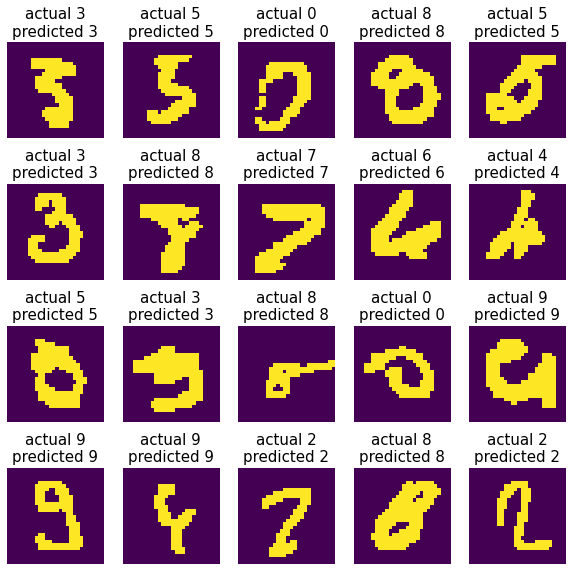

In [ ]:
plotWrongPredictions(getWrongPredictions(bn_model, device, test_loader))

loss=2.3428428173065186 batch_id=0:   0%|          | 1/469 [00:00<00:57,  8.10it/s]

LayerNorm Model + L2
Epoch 1


loss=0.1133485734462738 batch_id=468: 100%|██████████| 469/469 [00:58<00:00,  8.00it/s]



Train set: Average loss: 0.0019, Accuracy: 56025/60000 (93.38%)



loss=0.100192129611969 batch_id=0:   0%|          | 1/469 [00:00<00:56,  8.28it/s]


Test set: Average loss: 0.0827, Accuracy: 9751/10000 (97.51%)

Epoch 2


loss=0.028115609660744667 batch_id=468: 100%|██████████| 469/469 [00:58<00:00,  7.97it/s]



Train set: Average loss: 0.0005, Accuracy: 58738/60000 (97.90%)



loss=0.062492385506629944 batch_id=0:   0%|          | 1/469 [00:00<00:55,  8.39it/s]


Test set: Average loss: 0.0607, Accuracy: 9821/10000 (98.21%)

Epoch 3


loss=0.048175547271966934 batch_id=468: 100%|██████████| 469/469 [00:58<00:00,  8.04it/s]



Train set: Average loss: 0.0004, Accuracy: 59035/60000 (98.39%)



loss=0.04460461065173149 batch_id=0:   0%|          | 1/469 [00:00<00:55,  8.42it/s]


Test set: Average loss: 0.0493, Accuracy: 9838/10000 (98.38%)

Epoch 4


loss=0.043364133685827255 batch_id=468: 100%|██████████| 469/469 [00:59<00:00,  7.90it/s]



Train set: Average loss: 0.0004, Accuracy: 59149/60000 (98.58%)



loss=0.011542822234332561 batch_id=0:   0%|          | 1/469 [00:00<00:58,  7.95it/s]


Test set: Average loss: 0.0419, Accuracy: 9863/10000 (98.63%)

Epoch 5


loss=0.0063253589905798435 batch_id=468: 100%|██████████| 469/469 [01:00<00:00,  7.80it/s]



Train set: Average loss: 0.0003, Accuracy: 59252/60000 (98.75%)



loss=0.0492439903318882 batch_id=0:   0%|          | 1/469 [00:00<01:00,  7.76it/s]


Test set: Average loss: 0.0389, Accuracy: 9880/10000 (98.80%)

Epoch 6


loss=0.013792810030281544 batch_id=468: 100%|██████████| 469/469 [01:00<00:00,  7.73it/s]



Train set: Average loss: 0.0003, Accuracy: 59335/60000 (98.89%)



loss=0.031206760555505753 batch_id=0:   0%|          | 1/469 [00:00<01:00,  7.72it/s]


Test set: Average loss: 0.0337, Accuracy: 9904/10000 (99.04%)

Epoch 7


loss=0.01790156029164791 batch_id=468: 100%|██████████| 469/469 [01:00<00:00,  7.76it/s]



Train set: Average loss: 0.0003, Accuracy: 59401/60000 (99.00%)



loss=0.03923840820789337 batch_id=0:   0%|          | 1/469 [00:00<00:57,  8.09it/s]


Test set: Average loss: 0.0306, Accuracy: 9904/10000 (99.04%)

Epoch 8


loss=0.015208491124212742 batch_id=468: 100%|██████████| 469/469 [01:00<00:00,  7.80it/s]



Train set: Average loss: 0.0002, Accuracy: 59417/60000 (99.03%)



loss=0.00793983694165945 batch_id=0:   0%|          | 1/469 [00:00<00:59,  7.93it/s]


Test set: Average loss: 0.0345, Accuracy: 9886/10000 (98.86%)

Epoch 9


loss=0.03719213977456093 batch_id=468: 100%|██████████| 469/469 [01:00<00:00,  7.78it/s]



Train set: Average loss: 0.0002, Accuracy: 59445/60000 (99.08%)



loss=0.006476855371147394 batch_id=0:   0%|          | 1/469 [00:00<00:58,  8.04it/s]


Test set: Average loss: 0.0317, Accuracy: 9904/10000 (99.04%)

Epoch 10


loss=0.029226237908005714 batch_id=468: 100%|██████████| 469/469 [01:00<00:00,  7.77it/s]



Train set: Average loss: 0.0002, Accuracy: 59483/60000 (99.14%)



loss=0.02063215896487236 batch_id=0:   0%|          | 1/469 [00:00<00:56,  8.29it/s]


Test set: Average loss: 0.0315, Accuracy: 9904/10000 (99.04%)

Epoch 11


loss=0.0028793439269065857 batch_id=468: 100%|██████████| 469/469 [01:00<00:00,  7.81it/s]



Train set: Average loss: 0.0002, Accuracy: 59520/60000 (99.20%)



loss=0.011712010949850082 batch_id=0:   0%|          | 1/469 [00:00<00:57,  8.16it/s]


Test set: Average loss: 0.0321, Accuracy: 9896/10000 (98.96%)

Epoch 12


loss=0.034422121942043304 batch_id=468: 100%|██████████| 469/469 [01:00<00:00,  7.81it/s]



Train set: Average loss: 0.0002, Accuracy: 59552/60000 (99.25%)



loss=0.006427927408367395 batch_id=0:   0%|          | 1/469 [00:00<01:00,  7.75it/s]


Test set: Average loss: 0.0306, Accuracy: 9904/10000 (99.04%)

Epoch 13


loss=0.0070233275182545185 batch_id=468: 100%|██████████| 469/469 [00:59<00:00,  7.86it/s]



Train set: Average loss: 0.0002, Accuracy: 59569/60000 (99.28%)



loss=0.009407706558704376 batch_id=0:   0%|          | 1/469 [00:00<01:00,  7.79it/s]


Test set: Average loss: 0.0295, Accuracy: 9908/10000 (99.08%)

Epoch 14


loss=0.007637426257133484 batch_id=468: 100%|██████████| 469/469 [00:58<00:00,  7.96it/s]



Train set: Average loss: 0.0002, Accuracy: 59567/60000 (99.28%)



loss=0.024385221302509308 batch_id=0:   0%|          | 1/469 [00:00<00:57,  8.13it/s]


Test set: Average loss: 0.0273, Accuracy: 9917/10000 (99.17%)

Epoch 15


loss=0.06207039952278137 batch_id=468: 100%|██████████| 469/469 [00:59<00:00,  7.89it/s]



Train set: Average loss: 0.0002, Accuracy: 59578/60000 (99.30%)



loss=0.007149104028940201 batch_id=0:   0%|          | 1/469 [00:00<00:57,  8.14it/s]


Test set: Average loss: 0.0289, Accuracy: 9910/10000 (99.10%)

Epoch 16


loss=0.011509612202644348 batch_id=468: 100%|██████████| 469/469 [01:00<00:00,  7.79it/s]



Train set: Average loss: 0.0002, Accuracy: 59598/60000 (99.33%)



loss=0.003675886197015643 batch_id=0:   0%|          | 1/469 [00:00<00:57,  8.13it/s]


Test set: Average loss: 0.0280, Accuracy: 9916/10000 (99.16%)

Epoch 17


loss=0.031152375042438507 batch_id=468: 100%|██████████| 469/469 [00:59<00:00,  7.87it/s]



Train set: Average loss: 0.0002, Accuracy: 59645/60000 (99.41%)



loss=0.017586102709174156 batch_id=0:   0%|          | 1/469 [00:00<01:02,  7.45it/s]


Test set: Average loss: 0.0272, Accuracy: 9922/10000 (99.22%)

Epoch 18


loss=0.007957887835800648 batch_id=468: 100%|██████████| 469/469 [01:00<00:00,  7.80it/s]



Train set: Average loss: 0.0001, Accuracy: 59661/60000 (99.44%)



loss=0.0026431104633957148 batch_id=0:   0%|          | 1/469 [00:00<01:00,  7.70it/s]


Test set: Average loss: 0.0301, Accuracy: 9914/10000 (99.14%)

Epoch 19


loss=0.0064970869570970535 batch_id=468: 100%|██████████| 469/469 [00:59<00:00,  7.85it/s]



Train set: Average loss: 0.0001, Accuracy: 59647/60000 (99.41%)



loss=0.00484996335580945 batch_id=0:   0%|          | 1/469 [00:00<01:01,  7.63it/s]


Test set: Average loss: 0.0286, Accuracy: 9917/10000 (99.17%)

Epoch 20


loss=0.03212385252118111 batch_id=468: 100%|██████████| 469/469 [00:59<00:00,  7.86it/s]



Train set: Average loss: 0.0001, Accuracy: 59673/60000 (99.45%)



loss=0.029156925156712532 batch_id=0:   0%|          | 1/469 [00:00<01:00,  7.77it/s]


Test set: Average loss: 0.0269, Accuracy: 9917/10000 (99.17%)

Epoch 21


loss=0.025240063667297363 batch_id=468: 100%|██████████| 469/469 [00:59<00:00,  7.87it/s]



Train set: Average loss: 0.0001, Accuracy: 59686/60000 (99.48%)



loss=0.011271300725638866 batch_id=0:   0%|          | 1/469 [00:00<01:01,  7.56it/s]


Test set: Average loss: 0.0280, Accuracy: 9914/10000 (99.14%)

Epoch 22


loss=0.016316881403326988 batch_id=468: 100%|██████████| 469/469 [00:59<00:00,  7.83it/s]



Train set: Average loss: 0.0001, Accuracy: 59704/60000 (99.51%)



loss=0.008785027079284191 batch_id=0:   0%|          | 1/469 [00:00<01:01,  7.59it/s]


Test set: Average loss: 0.0313, Accuracy: 9900/10000 (99.00%)

Epoch 23


loss=0.02797374688088894 batch_id=468: 100%|██████████| 469/469 [01:00<00:00,  7.81it/s]



Train set: Average loss: 0.0001, Accuracy: 59706/60000 (99.51%)



loss=0.010792526416480541 batch_id=0:   0%|          | 1/469 [00:00<00:55,  8.37it/s]


Test set: Average loss: 0.0284, Accuracy: 9923/10000 (99.23%)

Epoch 24


loss=0.015169310383498669 batch_id=468: 100%|██████████| 469/469 [00:59<00:00,  7.84it/s]



Train set: Average loss: 0.0001, Accuracy: 59694/60000 (99.49%)



loss=0.009822229854762554 batch_id=0:   0%|          | 1/469 [00:00<00:57,  8.16it/s]


Test set: Average loss: 0.0308, Accuracy: 9906/10000 (99.06%)

Epoch 25


loss=0.014938016422092915 batch_id=468: 100%|██████████| 469/469 [00:59<00:00,  7.84it/s]



Train set: Average loss: 0.0001, Accuracy: 59722/60000 (99.54%)


Test set: Average loss: 0.0271, Accuracy: 9926/10000 (99.26%)



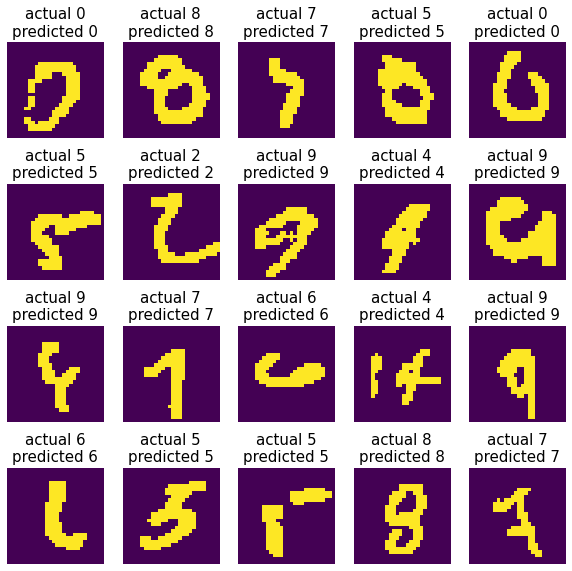

loss=2.4268667697906494 batch_id=0:   0%|          | 1/469 [00:00<00:59,  7.85it/s]

GroupNorm Model + L1
Epoch 1


loss=0.1507260799407959 batch_id=468: 100%|██████████| 469/469 [01:01<00:00,  7.61it/s]



Train set: Average loss: 0.0020, Accuracy: 56362/60000 (93.94%)



loss=0.13240167498588562 batch_id=0:   0%|          | 1/469 [00:00<00:59,  7.85it/s]


Test set: Average loss: 0.0834, Accuracy: 9751/10000 (97.51%)

Epoch 2


loss=0.057558245956897736 batch_id=468: 100%|██████████| 469/469 [01:01<00:00,  7.57it/s]



Train set: Average loss: 0.0008, Accuracy: 58741/60000 (97.90%)



loss=0.05500680208206177 batch_id=0:   0%|          | 1/469 [00:00<00:59,  7.84it/s]


Test set: Average loss: 0.0574, Accuracy: 9825/10000 (98.25%)

Epoch 3


loss=0.08192567527294159 batch_id=468: 100%|██████████| 469/469 [01:01<00:00,  7.63it/s]



Train set: Average loss: 0.0007, Accuracy: 59028/60000 (98.38%)



loss=0.09664186835289001 batch_id=0:   0%|          | 1/469 [00:00<01:00,  7.80it/s]


Test set: Average loss: 0.0424, Accuracy: 9870/10000 (98.70%)

Epoch 4


loss=0.08536526560783386 batch_id=468: 100%|██████████| 469/469 [01:01<00:00,  7.65it/s]



Train set: Average loss: 0.0006, Accuracy: 59168/60000 (98.61%)



loss=0.052131615579128265 batch_id=0:   0%|          | 1/469 [00:00<01:01,  7.60it/s]


Test set: Average loss: 0.0352, Accuracy: 9894/10000 (98.94%)

Epoch 5


loss=0.04931100457906723 batch_id=468: 100%|██████████| 469/469 [01:01<00:00,  7.65it/s]



Train set: Average loss: 0.0006, Accuracy: 59289/60000 (98.81%)



loss=0.07210606336593628 batch_id=0:   0%|          | 1/469 [00:00<00:59,  7.93it/s]


Test set: Average loss: 0.0411, Accuracy: 9879/10000 (98.79%)

Epoch 6


loss=0.06022299826145172 batch_id=468: 100%|██████████| 469/469 [01:00<00:00,  7.71it/s]



Train set: Average loss: 0.0006, Accuracy: 59337/60000 (98.89%)



loss=0.06871657073497772 batch_id=0:   0%|          | 1/469 [00:00<00:56,  8.26it/s]


Test set: Average loss: 0.0353, Accuracy: 9887/10000 (98.87%)

Epoch 7


loss=0.07270990312099457 batch_id=468: 100%|██████████| 469/469 [01:01<00:00,  7.67it/s]



Train set: Average loss: 0.0006, Accuracy: 59343/60000 (98.91%)



loss=0.08420248329639435 batch_id=0:   0%|          | 1/469 [00:00<00:58,  8.02it/s]


Test set: Average loss: 0.0303, Accuracy: 9898/10000 (98.98%)

Epoch 8


loss=0.05831460654735565 batch_id=468: 100%|██████████| 469/469 [01:01<00:00,  7.67it/s]



Train set: Average loss: 0.0005, Accuracy: 59403/60000 (99.00%)



loss=0.04641467705368996 batch_id=0:   0%|          | 1/469 [00:00<00:59,  7.86it/s]


Test set: Average loss: 0.0333, Accuracy: 9886/10000 (98.86%)

Epoch 9


loss=0.10896430909633636 batch_id=468: 100%|██████████| 469/469 [01:00<00:00,  7.70it/s]



Train set: Average loss: 0.0005, Accuracy: 59398/60000 (99.00%)



loss=0.04299795255064964 batch_id=0:   0%|          | 1/469 [00:00<01:00,  7.71it/s]


Test set: Average loss: 0.0283, Accuracy: 9908/10000 (99.08%)

Epoch 10


loss=0.05522659420967102 batch_id=468: 100%|██████████| 469/469 [01:01<00:00,  7.64it/s]



Train set: Average loss: 0.0005, Accuracy: 59418/60000 (99.03%)



loss=0.060081347823143005 batch_id=0:   0%|          | 1/469 [00:00<00:58,  8.03it/s]


Test set: Average loss: 0.0299, Accuracy: 9902/10000 (99.02%)

Epoch 11


loss=0.09262274205684662 batch_id=468: 100%|██████████| 469/469 [01:01<00:00,  7.63it/s]



Train set: Average loss: 0.0005, Accuracy: 59486/60000 (99.14%)



loss=0.07133098691701889 batch_id=0:   0%|          | 1/469 [00:00<00:58,  8.06it/s]


Test set: Average loss: 0.0280, Accuracy: 9908/10000 (99.08%)

Epoch 12


loss=0.0640062764286995 batch_id=468: 100%|██████████| 469/469 [01:01<00:00,  7.64it/s]



Train set: Average loss: 0.0005, Accuracy: 59498/60000 (99.16%)



loss=0.041327789425849915 batch_id=0:   0%|          | 1/469 [00:00<00:56,  8.22it/s]


Test set: Average loss: 0.0263, Accuracy: 9906/10000 (99.06%)

Epoch 13


loss=0.04655354470014572 batch_id=468: 100%|██████████| 469/469 [01:01<00:00,  7.68it/s]



Train set: Average loss: 0.0005, Accuracy: 59523/60000 (99.20%)



loss=0.04400511085987091 batch_id=0:   0%|          | 1/469 [00:00<01:02,  7.49it/s]


Test set: Average loss: 0.0273, Accuracy: 9911/10000 (99.11%)

Epoch 14


loss=0.04625770077109337 batch_id=468: 100%|██████████| 469/469 [01:01<00:00,  7.65it/s]



Train set: Average loss: 0.0005, Accuracy: 59485/60000 (99.14%)



loss=0.06651916354894638 batch_id=0:   0%|          | 1/469 [00:00<00:59,  7.86it/s]


Test set: Average loss: 0.0271, Accuracy: 9913/10000 (99.13%)

Epoch 15


loss=0.11532381176948547 batch_id=468: 100%|██████████| 469/469 [01:01<00:00,  7.66it/s]



Train set: Average loss: 0.0005, Accuracy: 59537/60000 (99.23%)



loss=0.04755067080259323 batch_id=0:   0%|          | 1/469 [00:00<00:58,  7.95it/s]


Test set: Average loss: 0.0261, Accuracy: 9908/10000 (99.08%)

Epoch 16


loss=0.045274652540683746 batch_id=468: 100%|██████████| 469/469 [01:01<00:00,  7.68it/s]



Train set: Average loss: 0.0005, Accuracy: 59537/60000 (99.23%)



loss=0.04107481241226196 batch_id=0:   0%|          | 1/469 [00:00<00:58,  8.04it/s]


Test set: Average loss: 0.0266, Accuracy: 9909/10000 (99.09%)

Epoch 17


loss=0.10710777342319489 batch_id=468: 100%|██████████| 469/469 [01:01<00:00,  7.69it/s]



Train set: Average loss: 0.0005, Accuracy: 59540/60000 (99.23%)



loss=0.06548133492469788 batch_id=0:   0%|          | 1/469 [00:00<00:57,  8.16it/s]


Test set: Average loss: 0.0357, Accuracy: 9872/10000 (98.72%)

Epoch 18


loss=0.03990354761481285 batch_id=468: 100%|██████████| 469/469 [01:01<00:00,  7.62it/s]



Train set: Average loss: 0.0005, Accuracy: 59554/60000 (99.26%)



loss=0.03854920715093613 batch_id=0:   0%|          | 1/469 [00:00<01:00,  7.73it/s]


Test set: Average loss: 0.0270, Accuracy: 9923/10000 (99.23%)

Epoch 19


loss=0.046733319759368896 batch_id=468: 100%|██████████| 469/469 [01:01<00:00,  7.62it/s]



Train set: Average loss: 0.0005, Accuracy: 59549/60000 (99.25%)



loss=0.056110039353370667 batch_id=0:   0%|          | 1/469 [00:00<00:58,  8.00it/s]


Test set: Average loss: 0.0247, Accuracy: 9915/10000 (99.15%)

Epoch 20


loss=0.06186753511428833 batch_id=468: 100%|██████████| 469/469 [01:01<00:00,  7.63it/s]



Train set: Average loss: 0.0004, Accuracy: 59597/60000 (99.33%)



loss=0.0407293327152729 batch_id=0:   0%|          | 1/469 [00:00<00:57,  8.12it/s]


Test set: Average loss: 0.0250, Accuracy: 9923/10000 (99.23%)

Epoch 21


loss=0.09693808853626251 batch_id=468: 100%|██████████| 469/469 [01:01<00:00,  7.63it/s]



Train set: Average loss: 0.0004, Accuracy: 59574/60000 (99.29%)



loss=0.066547691822052 batch_id=0:   0%|          | 1/469 [00:00<01:01,  7.67it/s]


Test set: Average loss: 0.0305, Accuracy: 9908/10000 (99.08%)

Epoch 22


loss=0.04436137527227402 batch_id=468: 100%|██████████| 469/469 [01:01<00:00,  7.58it/s]



Train set: Average loss: 0.0004, Accuracy: 59599/60000 (99.33%)



loss=0.08062221109867096 batch_id=0:   0%|          | 1/469 [00:00<01:03,  7.40it/s]


Test set: Average loss: 0.0284, Accuracy: 9914/10000 (99.14%)

Epoch 23


loss=0.04749933257699013 batch_id=468: 100%|██████████| 469/469 [01:01<00:00,  7.58it/s]



Train set: Average loss: 0.0004, Accuracy: 59585/60000 (99.31%)



loss=0.04336224123835564 batch_id=0:   0%|          | 1/469 [00:00<01:04,  7.24it/s]


Test set: Average loss: 0.0287, Accuracy: 9907/10000 (99.07%)

Epoch 24


loss=0.04764813929796219 batch_id=468: 100%|██████████| 469/469 [01:01<00:00,  7.65it/s]



Train set: Average loss: 0.0004, Accuracy: 59599/60000 (99.33%)



loss=0.07187150418758392 batch_id=0:   0%|          | 1/469 [00:00<00:59,  7.92it/s]


Test set: Average loss: 0.0279, Accuracy: 9914/10000 (99.14%)

Epoch 25


loss=0.04032757133245468 batch_id=468: 100%|██████████| 469/469 [01:00<00:00,  7.69it/s]



Train set: Average loss: 0.0004, Accuracy: 59595/60000 (99.33%)


Test set: Average loss: 0.0263, Accuracy: 9917/10000 (99.17%)



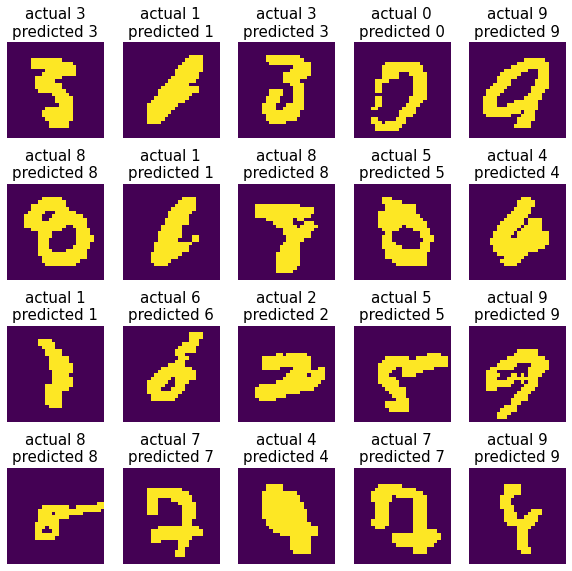

In [ ]:
torch.manual_seed(1)

print("LayerNorm Model + L2")
kwargs['weight_decay'] = 1e-5
kwargs['lambda_l1'] = None
ln_l2_output = fit(ln_model,  **kwargs)
plotWrongPredictions(getWrongPredictions(ln_model, device, test_loader))

torch.manual_seed(1)

print("GroupNorm Model + L1")
kwargs['weight_decay'] = 0
kwargs['lambda_l1'] = 0.0001
gn_l1_output = fit(gn_model,  **kwargs)
plotWrongPredictions(getWrongPredictions(gn_model, device, test_loader))

Text(0.5, 1.0, 'Test Accuracy')

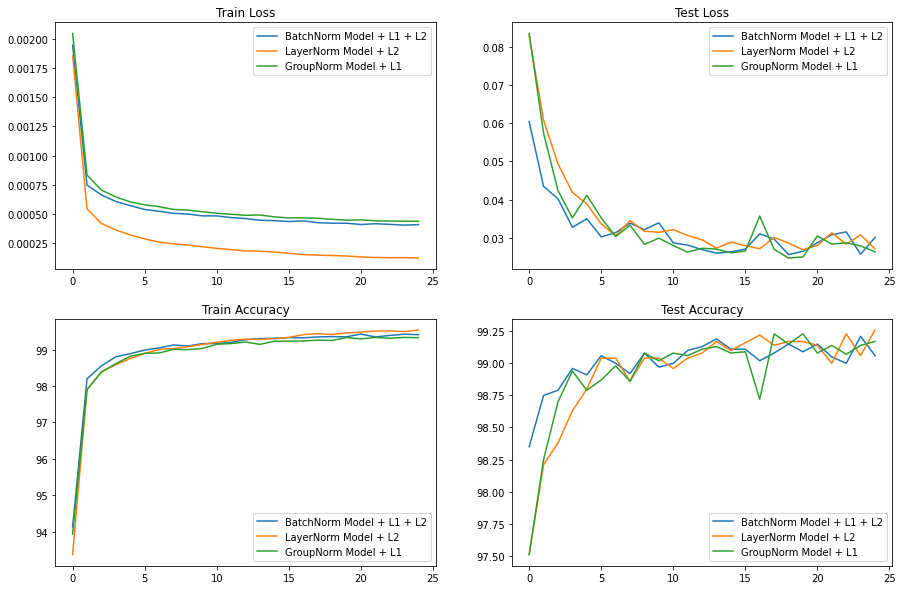

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 10]

plt.subplot(2,2, 1)
plt.plot(bn_l1_l2_output[2])
plt.plot(ln_l2_output[2])
plt.plot(gn_l1_output[2])
plt.legend(["BatchNorm Model + L1 + L2", "LayerNorm Model + L2", "GroupNorm Model + L1"])
plt.title("Train Loss")

plt.subplot(2,2,2)
plt.plot(bn_l1_l2_output[3])
plt.plot(ln_l2_output[3])
plt.plot(gn_l1_output[3])
plt.legend(["BatchNorm Model + L1 + L2", "LayerNorm Model + L2", "GroupNorm Model + L1"])
plt.title("Test Loss")

plt.subplot(2,2,3)
plt.plot(np.array(bn_l1_l2_output[0]))
plt.plot(np.array(ln_l2_output[0]))
plt.plot(np.array(gn_l1_output[0]))
plt.legend(["BatchNorm Model + L1 + L2", "LayerNorm Model + L2", "GroupNorm Model + L1"])
plt.title("Train Accuracy")

plt.subplot(2,2,4)
plt.plot(np.array(bn_l1_l2_output[1]))
plt.plot(np.array(ln_l2_output[1]))
plt.plot(np.array(gn_l1_output[1]))
plt.legend(["BatchNorm Model + L1 + L2", "LayerNorm Model + L2", "GroupNorm Model + L1"])
plt.title("Test Accuracy")
